In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import copy
import networkx as nx

## Load data 
Data comes from http://stat-computing.org/dataexpo/2009/. 
Flight data relates to the year 2007 (see file StatComp_MER) 

In [230]:
# Load data
Flights = pd.read_pickle("Flights.pkl")
Airports = pd.read_pickle("Airports.pkl")

# Select variables from which to create network. Must contain two columns of nodes, since 
# nx.from_pandas_edgelist() views each row as an edge. Can also contains attributes, e.g. Distance. 
Flights = Flights.loc[(Flights["Month"] == 1) & (Flights["DayofMonth"] == 10)]
FlightsNx = Flights[["Origin","Dest","Distance"]]

# Take counts (i.e. how many origin to destination flights in the dataset)
counts = pd.DataFrame(Flights.groupby(["Origin","Dest"])["Year"].count())
counts.columns = ["count"]
FlightsNx = FlightsNx.merge(counts, how = 'left', on = ["Origin","Dest"])

# Drop duplicates 
FlightsNx = FlightsNx.drop_duplicates()

In [233]:
# Count number of take-offs from origin: 
orig_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
orig_takeoff.columns = ["origin_takeoff"]
# Merge to network dataset: 
FlightsNx = FlightsNx.merge(orig_takeoff, how = "left", on = "Origin")

# Count number of take-offs from dest
dest_takeoff = pd.DataFrame(FlightsNx.groupby(["Origin"])["count"].sum())
dest_takeoff.columns = ["dest_takeoff"]
FlightsNx = FlightsNx.merge(dest_takeoff, how = "left", left_on = "Dest", right_on = "Origin")

# Count number of landings at destination
dest_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
dest_lands.columns = ["dest_landing"]
FlightsNx = FlightsNx.merge(dest_lands, how = "left", on = "Dest")

orig_lands = pd.DataFrame(FlightsNx.groupby(["Dest"])["count"].sum())
orig_lands.columns = ["orig_landing"]
FlightsNx = FlightsNx.merge(orig_lands, how = "left", left_on = "Origin", right_on = "Dest")

# Construct totals (flights)
FlightsNx["Origin_flights"] = FlightsNx["origin_takeoff"]+FlightsNx["orig_landing"]
FlightsNx["Destination_flights"] = FlightsNx["dest_takeoff"]+FlightsNx["dest_landing"]

# Drop auxiliary vars
FlightsNx.drop(["origin_takeoff","dest_takeoff","dest_landing","orig_landing"], axis = 1, inplace = True)

In [234]:
FlightsNx.head()

,Origin,Dest,Distance,count,Origin_flights,Destination_flights
0,ABQ,AMA,277,2,202.0,46
1,ABQ,BWI,1670,1,202.0,587
2,ABQ,DAL,580,7,202.0,308
3,ABQ,ELP,223,3,202.0,122
4,ABQ,HOU,759,3,202.0,316


#### Implement as network. 
For function documentation, see:  
https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html?highlight=from_pandas_edgelist#networkx.convert_matrix.from_pandas_edgelist  


In [235]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 281
Number of edges: 2088
Average degree:  14.8612


#### Sparse 

In [236]:
# calculate L_max:  
print("L_max = {}".format(len(Network.nodes)*(len(Network.nodes)-1)*(1/2)))
print(2868/47895)

L_max = 39340.0
0.05988098966489195


## Degree calculations

### Degree distribution

In [237]:
# docs: https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality 
# Find degree: 
degree_dict = nx.algorithms.centrality.degree_centrality(Network) 
degree_values = list(degree_dict.values())
# Create dataframe
degrees = pd.DataFrame(degree_values)
degrees.columns = ["degree"]
degrees["degree_unnormalized"] = degrees["degree"]*(len(Network.nodes)-1)
degrees["airport"] = degree_dict.keys()
degrees.head()

,degree,degree_unnormalized,airport
0,0.110714,31.0,ABQ
1,0.017857,5.0,AMA
2,0.200000,56.0,BWI
3,0.053571,15.0,DAL
4,0.060714,17.0,ELP


In [238]:
# Add degree to FlightsNx data
FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Origin", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1)
FlightsNx = FlightsNx.rename(columns = {"degree": "origin_degree", "degree_unnormalized": "origin_degree_unn"})

FlightsNx = FlightsNx.merge(degrees, how = "left", left_on = "Dest", right_on = "airport")
FlightsNx = FlightsNx.drop("airport", axis = 1)
FlightsNx = FlightsNx.rename(columns = {"degree": "dest_degree", "degree_unnormalized": "dest_degree_unn"})


In [239]:
# See most important airports in dataset.
degrees.sort_values(by = "degree_unnormalized", ascending = False).head()

,degree,degree_unnormalized,airport
91,0.600000,168.0,ATL
85,0.471429,132.0,ORD
70,0.453571,127.0,DFW
64,0.396429,111.0,IAH
34,0.389286,109.0,DTW


In [240]:
print(degrees.loc[(degrees["degree_unnormalized"] < 5)].shape[0])
print(degrees.loc[(degrees["degree_unnormalized"] > 100)].shape[0])

139
7


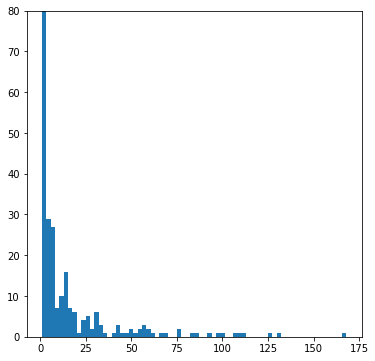

In [241]:
# Degree distribution
fig, ax = plt.subplots(figsize = (6,6))
plt.hist(degrees["degree_unnormalized"], bins = 70)
plt.ylim(0,80)
plt.show()

## Betweenness centrality
#### (node) betweenness centrality

In [146]:
btwn = nx.betweenness_centrality(Network)

In [170]:
betweenness = list(btwn.values())
btwn_df = pd.DataFrame(betweenness)
btwn_df.columns = ["betweenness"]
btwn_df["airport"] = btwn.keys()

In [182]:
btwn_df.sort_values(by = "betweenness", ascending = False)
Node_char = degrees.merge(btwn_df, on= "airport")

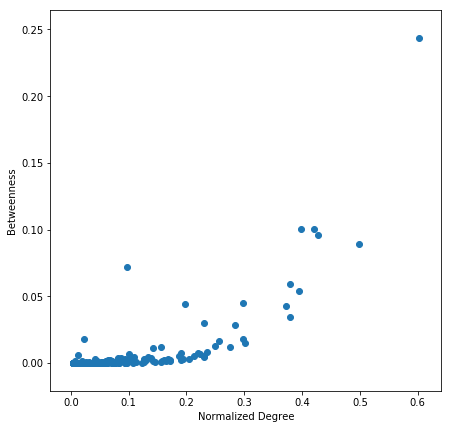

In [189]:
# Betweenness vs. degree
fig, ax = plt.subplots(figsize = (7,7))
plt.scatter(Node_char["degree"],Node_char["betweenness"])
plt.xlabel("Normalized Degree")
plt.ylabel("Betweenness")
plt.show()

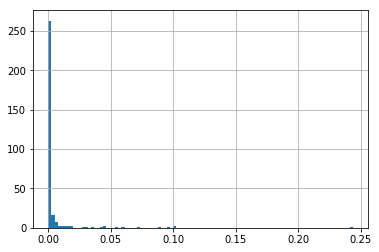

In [193]:
Node_char["betweenness"].hist(bins = 100)

In [194]:
avg_shrt_path_len = nx.average_shortest_path_length(Network)


In [203]:
test = FlightsNx.loc[(FlightsNx["Origin"] != "ATL") & (FlightsNx["Dest"] != "ATL")]
Nettest = nx.from_pandas_edgelist(test, source = "Origin", target = "Dest", edge_attr = None)
ATL_avg = nx.average_shortest_path_length(Nettest)
print(ATL_avg)

2.3350512969415407


# Attacks and Errors
## Analysis of how removing certain airports affect network characteristics

#### Measures for entire network

In [242]:
print(nx.info(Network))
print("The average shortest path is: {}".format(nx.average_shortest_path_length(Network)))
print("The average clustering coefficient is: {}".format(nx.average_clustering(Network)))
print("The diameter of the network is: {}".format(nx.diameter(Network)))
print("The global efficiency of the network is: {}".format(nx.global_efficiency(Network)))

Name: 
Type: Graph
Number of nodes: 281
Number of edges: 2088
Average degree:  14.8612
The average shortest path is: 2.3511947127605493
The average clustering coefficient is: 0.6505430003500363
The diameter of the network is: 4
The global efficiency of the network is: 0.46252118285030347


#### Mapping airport network geographically

In [244]:
# Get list of nodes, and add lat, lon from Airports dataset:
nodes = pd.DataFrame(list(Network.nodes()))
nodes.columns = ["3DigitId"]
positions = nodes.merge(Airports[["3DigitId","Lat","Lon"]], how = "left", on = "3DigitId")

# Create a positions dictionary, which is in the format necessary to add it as a node attribute.
pos_= dict()
for idx, row in positions.iterrows():
    pos_[row['3DigitId']] = dict(pos=(row['Lat'], row['Lon']))

# Set the node attributes. 
nx.set_node_attributes(Network, pos_)

In [245]:
# Split airports according to size/importance for plotting purposes:
attributes = positions.merge(FlightsNx[["Origin","Origin_flights","origin_degree_unn"]], how = "left", left_on = "3DigitId", right_on = "Origin").drop_duplicates()
attributes = attributes.sort_values(by = "origin_degree_unn", ascending = False)

hubs_small = list(attributes.loc[attributes["origin_degree_unn"]>25]["Origin"])
hubs = list(attributes.loc[attributes["origin_degree_unn"]>50]["Origin"])
hubs_large = list(attributes.loc[attributes["origin_degree_unn"]>100]["Origin"])

In [246]:
# Get geographical file from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Select US: 
US = world[(world.pop_est>0) & (world.name == "United States")]

C:\Users\morte\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


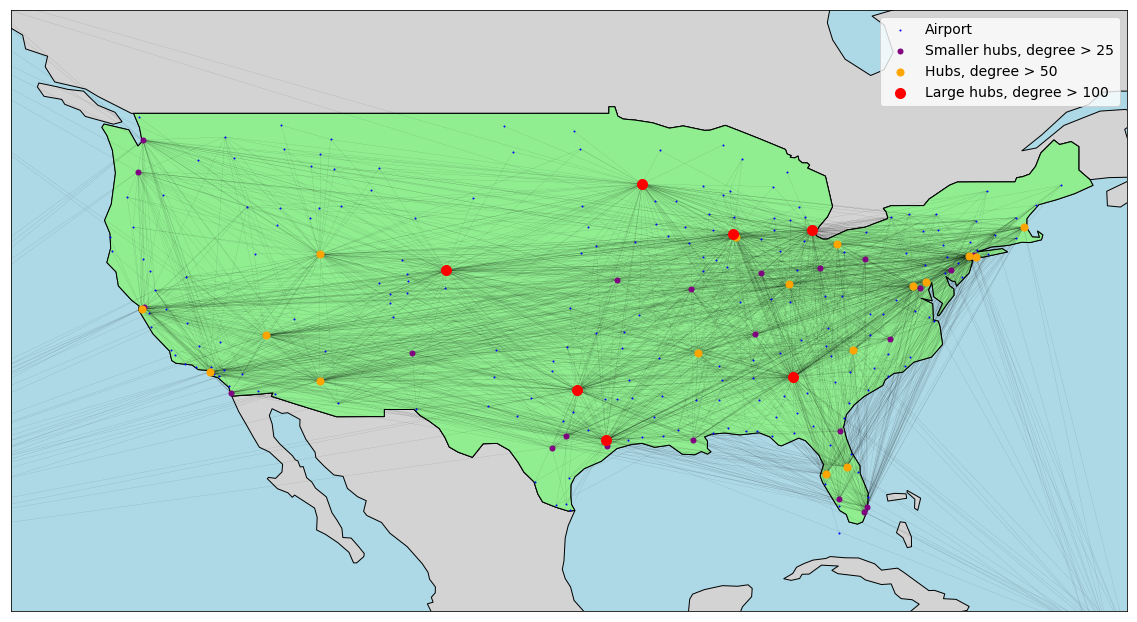

In [247]:
fig, ax = plt.subplots(figsize = (20,12))
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(Network, 'pos').items()}
world.plot(ax = ax, color = "lightgrey", edgecolor = "black")
US.plot(ax = ax, color = "lightgreen", edgecolor = "black")
plt.xlim(-130,-65)
plt.ylim(20,55)
ax.set_facecolor("lightblue")
plt.xticks([])
plt.yticks([])
nx.draw_networkx_edges(Network, pos, with_labels=False, width=0.05, ax = ax)
nx.draw_networkx_nodes(Network, pos, with_labels=False, node_size=1, ax = ax, node_color = "blue").set_label("Airport")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs_small, with_labels=False, node_size=25, ax = ax, node_color = "purple").set_label("Smaller hubs, degree > 25")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs, with_labels=False, node_size=50, ax = ax, node_color = "orange").set_label("Hubs, degree > 50")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs_large, with_labels=False, node_size=100, ax = ax, node_color = "red").set_label("Large hubs, degree > 100")
#nx.draw_networkx_labels(Network, pos, nodelist = hubs_large)
plt.legend(fontsize = 14)
plt.show()